In [1]:
%matplotlib inline

In [2]:
def nearest_neighbor_mask(x, xc):
    xdist = np.abs(x - xc)
    return np.argsort(xdist)

In [3]:
from rescale_dc2.load_catalogs import load_closest_available_umachine_catalog
umachine_z0 = load_closest_available_umachine_catalog(0.)
umachine_z1 = load_closest_available_umachine_catalog(1.)

In [4]:
import os
dirname = "/Users/aphearin/Dropbox/protoDC2"
sdss_basename = "volume_complete_sdss.hdf5"
protoDC2_basename = "value_added_protoDC2_snapnum_487.hdf5"

from astropy.table import Table
sdss = Table.read(os.path.join(dirname, sdss_basename), path='data')
protoDC2_z0 = Table.read(os.path.join(dirname, protoDC2_basename), path='data')

print(protoDC2_z0.keys())

['totalLuminositiesStellar:SDSS_r:observed', 'diskLuminositiesStellar:SDSS_r:observed', 'spheroidLuminositiesStellar:SDSS_r:observed', 'totalLuminositiesStellar:SDSS_g:observed', 'diskLuminositiesStellar:SDSS_g:observed', 'spheroidLuminositiesStellar:SDSS_g:observed', 'infallHaloMass', 'hostHaloMass', 'hostIndex', 'isCentral', 'spheroidMassStellar', 'totalMassStellar', 'galaxyID', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'totalStarFormationRate', 'mstar_percentile_fixed_infallHaloMass']


In [5]:
def compute_log10_ssfr_protoDC2(catalog, quenched_sequence_center=-13.5):
    ssfr = catalog['totalStarFormationRate']/catalog['totalMassStellar']
    zero_mask = ssfr == 0.
    nzeros = np.count_nonzero(zero_mask)
    ssfr[zero_mask] = 10**np.random.normal(loc=quenched_sequence_center, scale=0.2, size=nzeros)
    return np.log10(ssfr)-9.

protoDC2_z0['ssfr'] = compute_log10_ssfr_protoDC2(protoDC2_z0)

In [11]:
from halotools.empirical_models import conditional_abunmatch

protoDC2_z0['remapped_ssfr'] = protoDC2_z0['ssfr']

cenmask_um = umachine_z0['upid'] == -1
satmask_um = ~cenmask_um

cenmask_dc2 = protoDC2_z0['isCentral']
satmask_dc2 = ~protoDC2_z0['isCentral']

logsm_bins=np.linspace(9, 12, 25)
for low_sm, high_sm in zip(logsm_bins[:-1], logsm_bins[1:]):
    sm_mask_dc2 = protoDC2_z0['totalMassStellar'] > 10**low_sm
    sm_mask_dc2 *= protoDC2_z0['totalMassStellar'] < 10**high_sm
    cenmask_dc2 = sm_mask_dc2 * (protoDC2_z0['isCentral']==True)
    satmask_dc2 = sm_mask_dc2 * (protoDC2_z0['isCentral']==False)


    mid_sm = 0.5*(low_sm + high_sm)
    idx_censelect = nearest_neighbor_mask(umachine_z0['obs_sm'][cenmask_um], 10**mid_sm)
    idx_satselect = nearest_neighbor_mask(umachine_z0['obs_sm'][satmask_um], 10**mid_sm)
    
    um_ssfr_cens = umachine_z0['obs_ssfr'][cenmask_um][idx_censelect[:1000]]
    ssfr_cens = conditional_abunmatch(protoDC2_z0['ssfr'][cenmask_dc2], um_ssfr_cens)

    um_ssfr_sats = umachine_z0['obs_ssfr'][satmask_um][idx_satselect[:1000]]
    ssfr_sats = conditional_abunmatch(protoDC2_z0['ssfr'][satmask_dc2], um_ssfr_sats)


    protoDC2_z0['remapped_ssfr'][cenmask_dc2] = ssfr_cens
    protoDC2_z0['remapped_ssfr'][satmask_dc2] = ssfr_sats


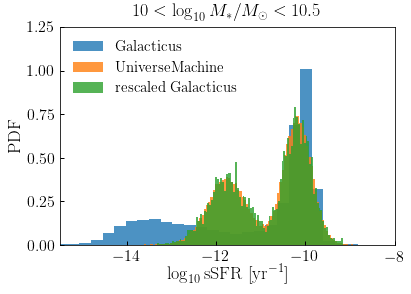

In [15]:
low_sm, high_sm = 10, 10.25
sm_mask = protoDC2_z0['totalMassStellar'] > 10**low_sm
sm_mask *= protoDC2_z0['totalMassStellar'] < 10**high_sm

sm_mask2 = umachine_z0['obs_sm'] > 10**low_sm
sm_mask2 *= umachine_z0['obs_sm'] < 10**high_sm


fig, ax = plt.subplots(1, 1)

__=ax.hist(protoDC2_z0['ssfr'][sm_mask], normed=True, alpha=0.8, bins=100, 
          label=r'${\rm Galacticus}$')
__=ax.hist(umachine_z0['obs_ssfr'][sm_mask2], normed=True, alpha=0.8, bins=100, 
           label=r'${\rm UniverseMachine}$')
__=ax.hist(protoDC2_z0['remapped_ssfr'][sm_mask], normed=True, alpha=0.8, bins=100, 
           label=r'${\rm rescaled\ Galacticus}$')
xlabel = ax.set_xlabel(r'$\log_{10}{\rm sSFR}\ [{\rm yr}^{-1}]$')
ylabel = ax.set_ylabel(r'${\rm PDF}$')
legend = ax.legend()
xlim = ax.set_xlim(-15.5, -8)
ylim = ax.set_ylim(0, 1.25)
title = ax.set_title(r'$10 < \log_{10}M_{\ast}/M_{\odot} < 10.5$')

figname = 'ssfr_distribution_comparison_10p5.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [ ]:
from halotools.empirical_models import conditional_abunmatch

low_sm, high_sm = 10, 10.25

sm_mask2 = umachine_z0['obs_sm'] > 10**low_sm
sm_mask2 *= umachine_z0['obs_sm'] < 10**high_sm

data = umachine_z0['obs_ssfr'][sm_mask2]

num_halos = int(1e4)
uran = np.random.rand(num_halos)
mock = conditional_abunmatch(uran, data)

fig, ax = plt.subplots(1, 1)

__=ax.hist(data, bins=150, normed=True, alpha=0.8)
__=ax.hist(mock, bins=150, normed=True, alpha=0.8)

In [ ]:
from halotools.empirical_models import conditional_abunmatch

remapped_ssfr = np.zeros(len(protoDC2_z0))
logsm_bins=np.linspace(9, 12, 25)
for lowsm, highsm in zip(logsm_bins[:-1], logsm_bins[1:]):
    sm_mask_um = umachine_z0['obs_sm'] > 10**low_sm
    sm_mask_um *= umachine_z0['obs_sm'] < 10**high_sm
    cenmask_um = sm_mask_um * (umachine_z0['upid']==-1)
    satmask_um = sm_mask_um * (umachine_z0['upid']!=-1)

    sm_mask_dc2 = protoDC2_z0['totalMassStellar'] > 10**low_sm
    sm_mask_dc2 *= protoDC2_z0['totalMassStellar'] < 10**high_sm
    cenmask_dc2 = sm_mask_dc2 * (protoDC2_z0['isCentral']==True)
    satmask_dc2 = sm_mask_dc2 * (protoDC2_z0['isCentral']==False)
    
    ssfr_cens = conditional_abunmatch(protoDC2_z0['ssfr'][cenmask_dc2], 
                                      umachine_z0['obs_ssfr'][cenmask_um])
    ssfr_sats = conditional_abunmatch(protoDC2_z0['ssfr'][satmask_dc2], 
                                      umachine_z0['obs_ssfr'][satmask_um])
    remapped_ssfr[cenmask_dc2] = ssfr_cens
    remapped_ssfr[satmask_dc2] = ssfr_sats

protoDC2_z0['ssfr'] = remapped_ssfr